In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")) + '/lib/')
import torch
import numpy as np
import pandas as pd  
import torch.nn as nn
from torch_geometric.data import DataLoader
from lib.net import GNN_Net
from lib.pytorchtools import check_gpu, plot_pred

## 1. Define Main Loop for GNN Testing

In [2]:
def main(train_data_dir, test_data_dir):

    ####  1. Testing Parameter Setting  ####

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  ## device defination

    model = GNN_Net().to(device)  ## GNN model loading

    # criterion = nn.MSELoss()  # MSE Loss
    criterion = nn.L1Loss()  # MAE Loss


    ####  2. Dataset Loading  ####

    graph_list_dir = os.path.join(test_data_dir, 'Test_data_list.pt')  ## test set dir
    graph_list = torch.load(graph_list_dir)  ## load voronoi graph dataset
    np.random.shuffle(graph_list)  ## shuffle the dataset
    np.random.shuffle(graph_list)  ## shuffle the dataset
    testloader = DataLoader(graph_list, batch_size=1, shuffle=False, drop_last=True)  ## test dataset


    ####  3. Start Testing  ####

    test_loss = 0
    batch_num = 0
    
    meta_list = [{'pred_1':'', 'target_1':'', 'error_1':'','pred_2':'','target_2':'','error_2':'',}] 
    df = pd.DataFrame(meta_list, columns = ['pred_1', 'target_1','error_1','pred_2','target_2','error_2'])  ## record prediction details

    model.eval()  ## set as evaluation mode

    model_file = train_data_dir + r'/best_model.pth'  ## best model in training

    with torch.no_grad():  

        for data in testloader: 

            data = data.to(device)  ## load batch data

            model.load_state_dict(torch.load(model_file, map_location='cuda:0'))  ## load in best model
            # model.load_state_dict(torch.load('checkpoint.pt'))

            outputs = model(data)  ## GNN model prediction output

            test_loss += criterion(outputs, (data.t).view(outputs.size()))  ## calculate loss  

            pred_1 = (outputs.cpu())[0][0]  ## pred pose_2--Y
            pred_2 = (outputs.cpu())[0][1]  ## pred pose_6--Theta_roll

            target_1 = ((data.cpu().t).view(outputs.size()))[0][0]  ## true pose_2--Y
            target_2 = ((data.cpu().t).view(outputs.size()))[0][1]  ## true pose_6--Theta_roll 

            error_1 = abs((outputs.cpu())[0][0] - ((data.cpu().t).view(outputs.size()))[0][0])  ## error pose_2--Y
            error_2 = abs((outputs.cpu())[0][1] - ((data.cpu().t).view(outputs.size()))[0][1])  ## error pose_6--Theta_roll

            df.loc[batch_num] = [pred_1, target_1, error_1, pred_2, target_2, error_2]  ## write prediction details

            batch_num += 1

    print(f'Test Loss: {test_loss / batch_num:.5f}', end='  ')  ## Test loss

    test_pred_file_dir = os.path.join(test_data_dir, 'prediction.csv')

    df.to_csv(test_pred_file_dir)  ## save prediction details as csv file
    
    ## plot the test results
    fig = plot_pred(pred_df = df, target_names = ["pose_2", "pose_6"], model_file = model_file, meta_dir = test_data_dir, poses_rng = [[0, 0, 0, 0, 0, 20], [0, -4, 0, 0, 0, -20]])
    fig.savefig(os.path.join(test_data_dir, "errors.png"), bbox_inches='tight') 



## 2. Run Main Loop for GNN Testing

device_count: 1
current_device: 0
device_name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
device_capability: (8, 6)
device_properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3070 Ti Laptop GPU', major=8, minor=6, total_memory=8191MB, multi_processor_count=46)
is_available: True


d:\Anaconda\install\envs\GNN\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Test Loss: 0.53288  

d:\2023_first_half\Tac-VGNN\lib\pytorchtools.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(sort_df[f"target_{i+1}"], sort_df[f"pred_{i+1}"], s=1, c = 'k', cmap="inferno") ##c=sort_df[f"target_{i+1}"],


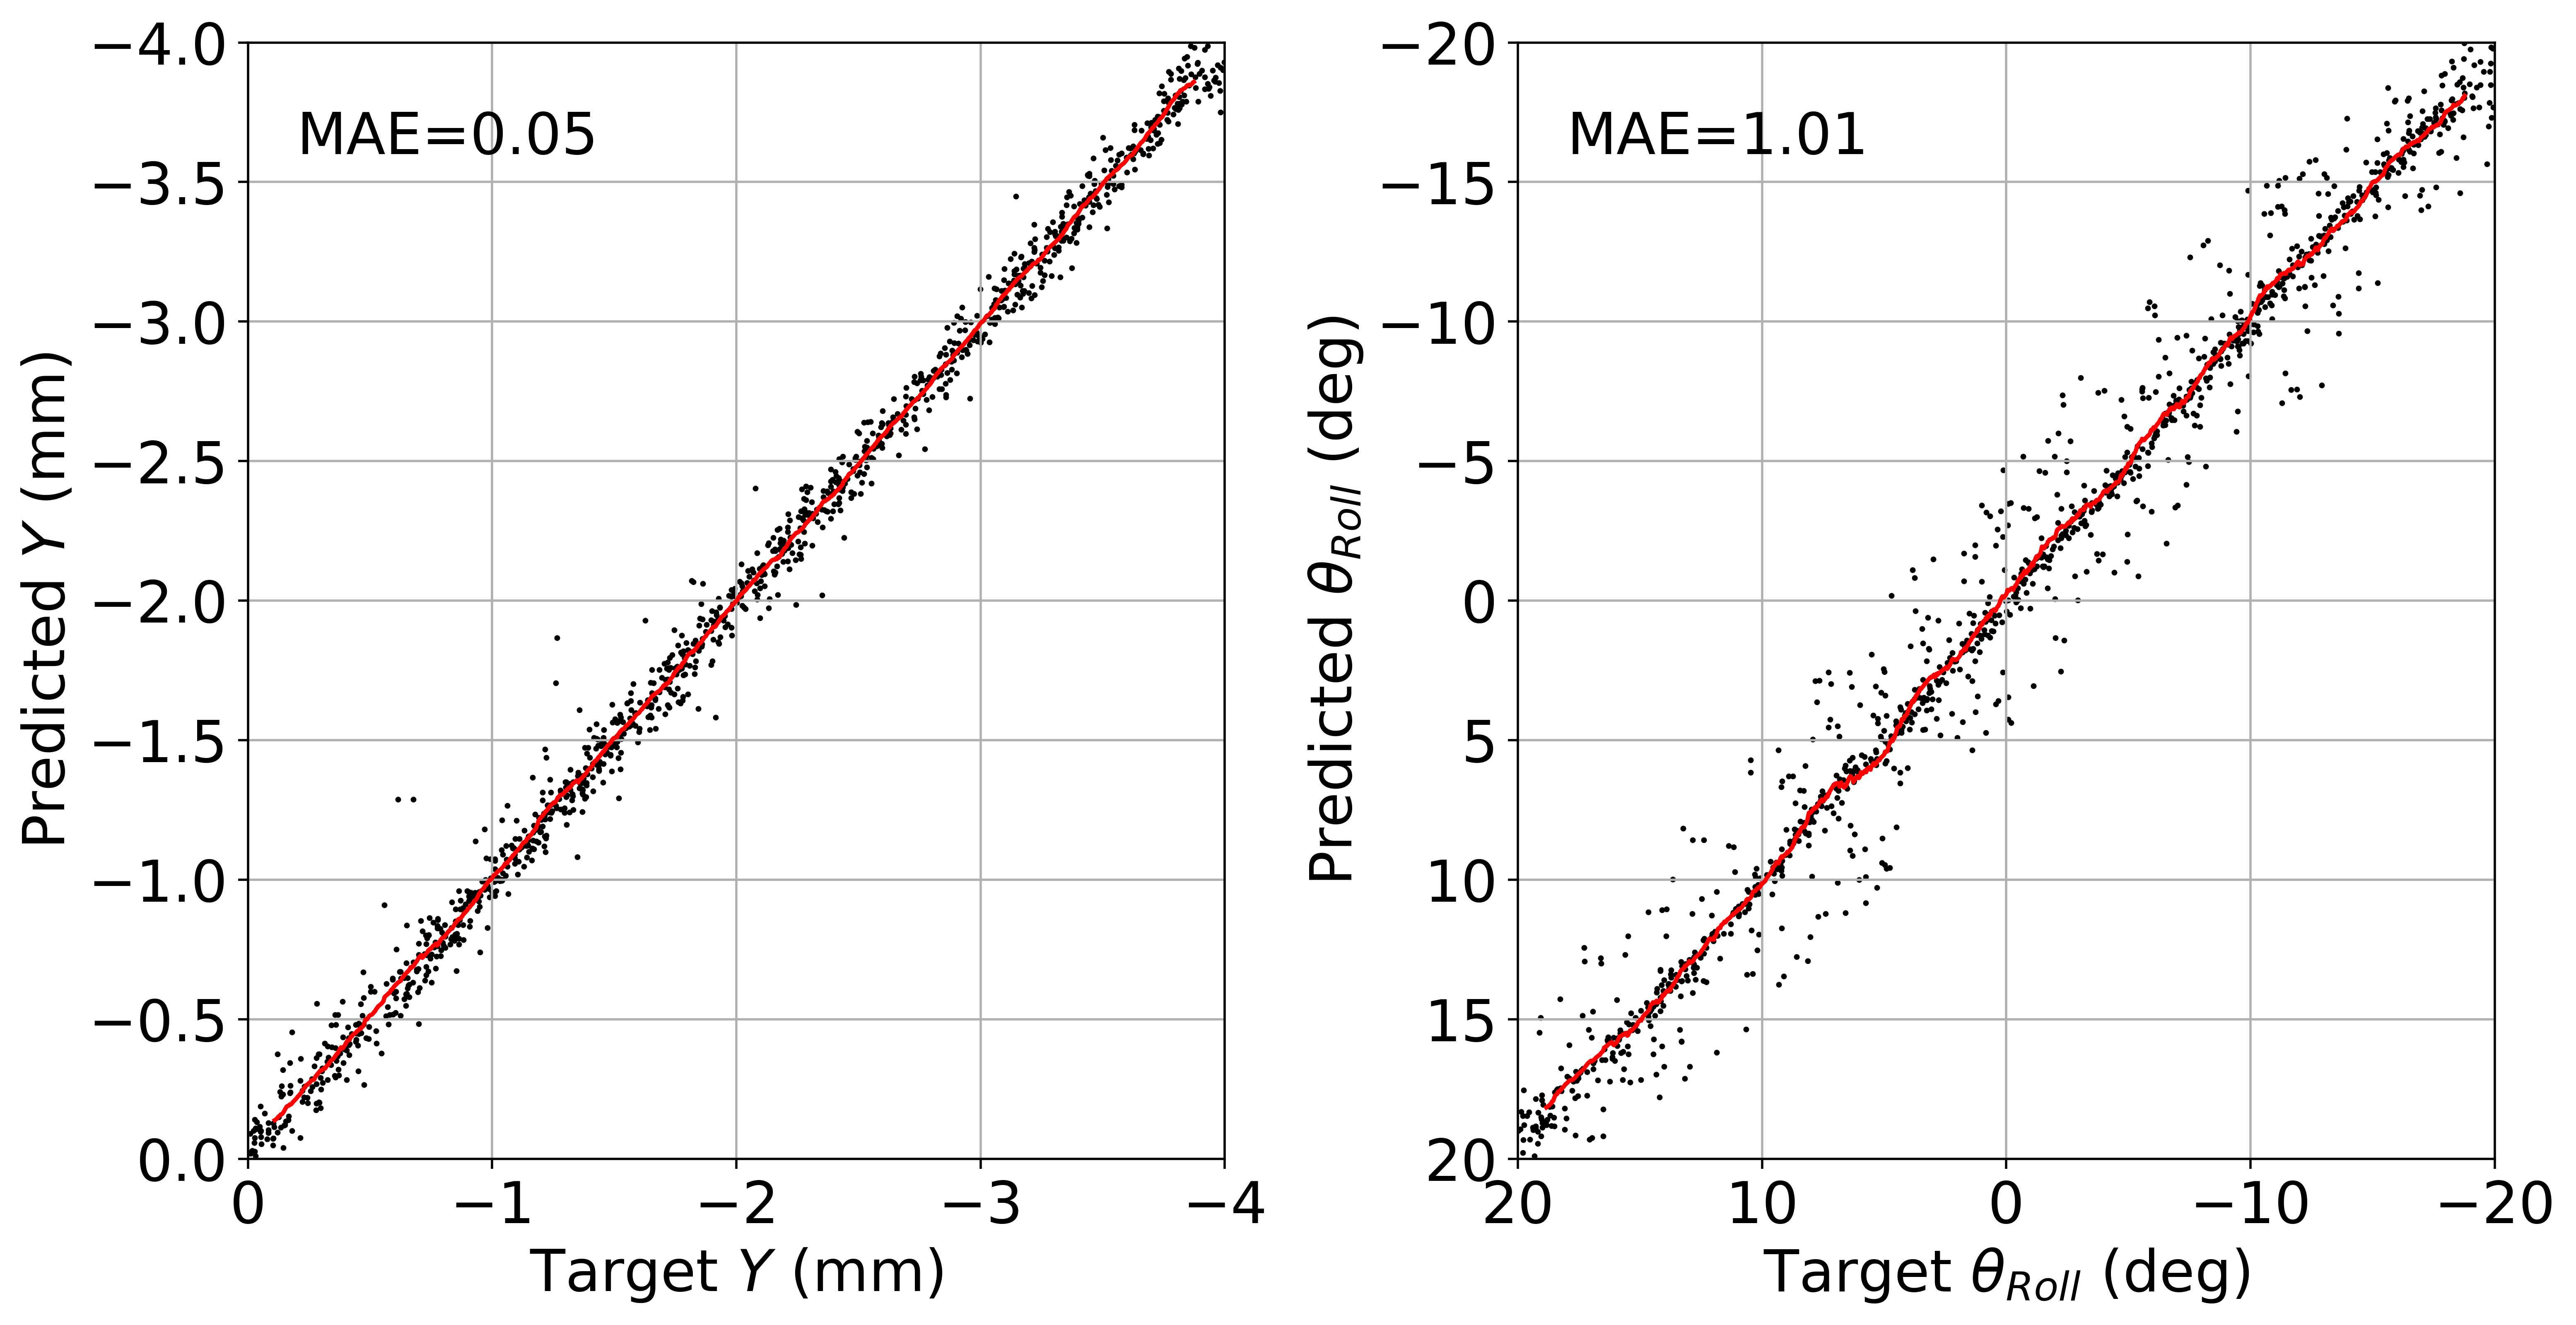

In [3]:
train_data_dir = r'..\result\train'  ## train data dir
test_data_dir = r'..\result\test'  ## test data dir

check_gpu(0)  ## set gpu device id

if __name__ == "__main__":
    
    main(train_data_dir, test_data_dir)